<a href="https://colab.research.google.com/github/MaxiRome/datasets/blob/main/Tarea_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Maximiliano Romero

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Subir datasets de dígitos (train)

In [ ]:
!wget https://github.com/MaxiRome/datasets/raw/main/1_digits_train.txt
!wget https://github.com/MaxiRome/datasets/raw/main/1_digits_test.txt

--2023-10-28 19:58:23--  https://github.com/MaxiRome/datasets/raw/main/1_digits_train.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxiRome/datasets/main/1_digits_train.txt [following]
--2023-10-28 19:58:23--  https://raw.githubusercontent.com/MaxiRome/datasets/main/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt’

1_digits_train.txt  100%[===================>] 625.59K  --.-KB/s    in 0.05s   

2023-10-28 19:58:24 (11.8 MB/s) - ‘1_digits_train.txt’ saved [640604/640604]

--2023-10-28 19:58:24--  https://github.co

## Leer dataset de dígitos

In [ ]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [ ]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [ ]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [ ]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [ ]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-7-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-7-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-7-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

In [ ]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear datasets y dataloaders para pytorch (train)

In [ ]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [ ]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [ ]:
# Función para crear y entrenar la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation_function):
        super(NeuralNetwork, self).__init__()
        if hidden_size2 is not None:  # si aparece otra capa oculta crea una red con 2 capas ocultas
            self.layers = nn.Sequential(
                nn.Linear(input_size, hidden_size1),
                activation_function,  # Funcion de activacion
                nn.Linear(hidden_size1, hidden_size2),
                activation_function,
                nn.Linear(hidden_size2, output_size)
            )
        else:
            self.layers = nn.Sequential(    # Si no aparece otra capa oculta crea una red con solo una capa oculta
                nn.Linear(input_size, hidden_size1),
                activation_function,
                nn.Linear(hidden_size1, output_size)
            )

    def forward(self, x):  # Propagacion hacia adelante a traves de las capas de la red
        return self.layers(x)

# Tamaño de lotes de datos y numero de epocas antes de overfitting
batch_size = 128
overfitting = 15

# Función para entrenar el modelo con un conjunto de datos de entrenamiento y validación
def train_model(model, dataloader_train, dataloader_val):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)  # Mueve el modelo a GPU

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_validation_loss = float('inf')
    epochs_without_improvement = 0

    loss_train = []  # Almacena la perdida de entrenamiento
    loss_val = []    # Almacena la perdida de validacion

    start = time.time() # Tiempo de inicio del entrenamiento

    for epoch in range(1000):   # Bucle de entrenamiento con un máximo de 1000 épocas
        loss_train_batches = [] # Lista para almacenar la pérdida en lotes de entrenamiento
        loss_val_batches = []   # Lista para almacenar la pérdida en lotes de validación


        model.train() # Establece el modelo en modo de entrenamiento
        for i, data in enumerate(dataloader_train, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train_batches.append(loss.item())

        loss_train.append(np.mean(loss_train_batches))

        model.eval() # Establece el modelo en modo de evaluación
        with torch.no_grad():
            for i, data in enumerate(dataloader_val, 0):
                inputs = data["features"].to(device)
                labels = data["labels"].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss_val_batches.append(loss.item())

        loss_val.append(np.mean(loss_val_batches))

        print("Epoch: %d, train loss: %.4f, val loss: %.4f" % (epoch, loss_train[epoch], loss_val[epoch]))

        if loss_val[epoch] < best_validation_loss:
            best_validation_loss = loss_val[epoch]
            torch.save(model.state_dict(), 'best_model_checkpoint.pth')
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= overfitting:
            break

    end = time.time() # Registra el tiempo de finalización del entrenamiento
    print('Finished Training, total time %f seconds' % (end - start))

    return loss_train, loss_val

# Función para graficar la pérdida de entrenamiento y validación
def plot_loss(epochs, loss_train, loss_val):
    plt.figure(figsize=(8, 5))
    plt.title('Gráfico del loss de entrenamiento y el de validación en función del tiempo')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.plot(epochs, loss_train, 'purple', label='Entrenamiento')
    plt.plot(epochs, loss_val, 'blue', label='Validación')
    plt.grid()
    plt.legend()
    plt.show()

# Función para evaluar el modelo en un conjunto de datos de prueba
def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for i, data in enumerate(dataloader, 0):
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions, normalize='true') # Calcula la matriz de confusión
    accuracy = accuracy_score(all_labels, all_predictions) # Calcula la precisión del modelo

    disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_labels)) # Visualiza la matriz de confusión
    disp = disp.plot(cmap="viridis", values_format='.2f')

    print("Precisión: ", accuracy)

Epoch: 0, train loss: 2.2726, val loss: 2.1873
Epoch: 1, train loss: 2.1201, val loss: 2.0367
Epoch: 2, train loss: 1.9443, val loss: 1.8403
Epoch: 3, train loss: 1.7463, val loss: 1.6416
Epoch: 4, train loss: 1.5328, val loss: 1.4175
Epoch: 5, train loss: 1.3210, val loss: 1.2366
Epoch: 6, train loss: 1.1314, val loss: 1.0566
Epoch: 7, train loss: 0.9717, val loss: 0.9143
Epoch: 8, train loss: 0.8373, val loss: 0.8062
Epoch: 9, train loss: 0.7287, val loss: 0.6995
Epoch: 10, train loss: 0.6384, val loss: 0.6064
Epoch: 11, train loss: 0.5656, val loss: 0.5440
Epoch: 12, train loss: 0.5056, val loss: 0.4819
Epoch: 13, train loss: 0.4560, val loss: 0.4415
Epoch: 14, train loss: 0.4138, val loss: 0.4016
Epoch: 15, train loss: 0.3788, val loss: 0.3899
Epoch: 16, train loss: 0.3499, val loss: 0.3473
Epoch: 17, train loss: 0.3241, val loss: 0.3324
Epoch: 18, train loss: 0.3025, val loss: 0.3061
Epoch: 19, train loss: 0.2834, val loss: 0.2904
Epoch: 20, train loss: 0.2686, val loss: 0.2665
Ep

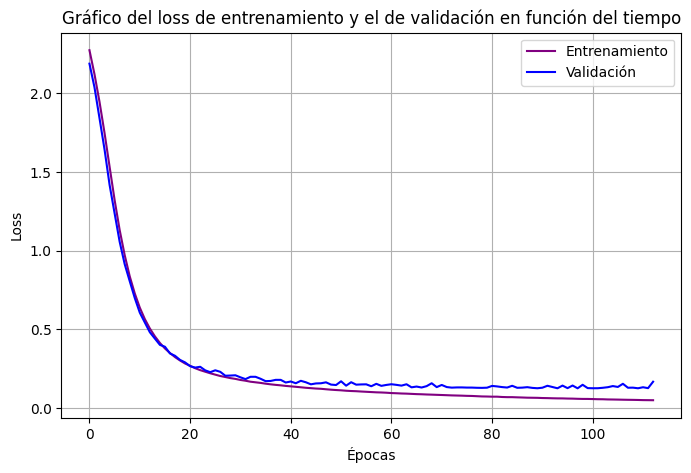

Precisión:  0.963984674329502


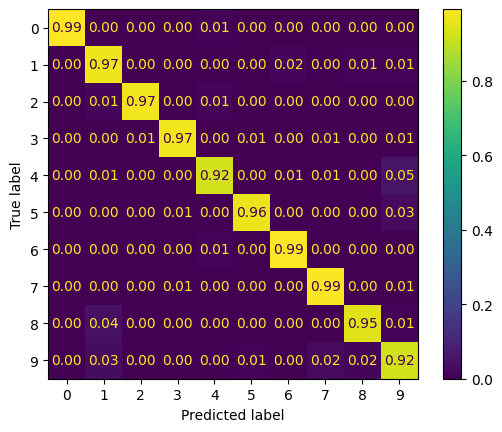

In [ ]:
model1 = NeuralNetwork(input_size=64, hidden_size1=10, hidden_size2=None, output_size=10, activation_function=nn.ReLU())
loss_train1, loss_val1 = train_model(model1, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(model1, dataloader_val)

Epoch: 0, train loss: 2.1087, val loss: 1.8894
Epoch: 1, train loss: 1.6965, val loss: 1.4661
Epoch: 2, train loss: 1.2666, val loss: 1.0507
Epoch: 3, train loss: 0.8914, val loss: 0.7364
Epoch: 4, train loss: 0.6279, val loss: 0.5407
Epoch: 5, train loss: 0.4659, val loss: 0.4178
Epoch: 6, train loss: 0.3664, val loss: 0.3389
Epoch: 7, train loss: 0.3018, val loss: 0.2863
Epoch: 8, train loss: 0.2586, val loss: 0.2555
Epoch: 9, train loss: 0.2265, val loss: 0.2357
Epoch: 10, train loss: 0.2011, val loss: 0.2079
Epoch: 11, train loss: 0.1815, val loss: 0.1860
Epoch: 12, train loss: 0.1666, val loss: 0.1759
Epoch: 13, train loss: 0.1527, val loss: 0.1766
Epoch: 14, train loss: 0.1411, val loss: 0.1603
Epoch: 15, train loss: 0.1308, val loss: 0.1466
Epoch: 16, train loss: 0.1226, val loss: 0.1464
Epoch: 17, train loss: 0.1143, val loss: 0.1369
Epoch: 18, train loss: 0.1077, val loss: 0.1293
Epoch: 19, train loss: 0.1018, val loss: 0.1237
Epoch: 20, train loss: 0.0959, val loss: 0.1153
Ep

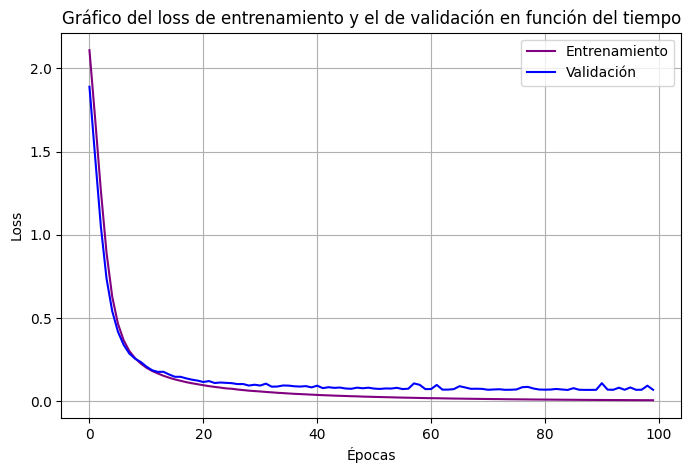

Precisión:  0.9800766283524904


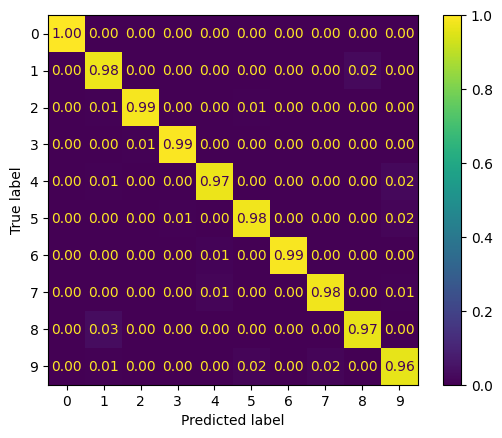

In [ ]:
model1 = NeuralNetwork(input_size=64, hidden_size1=40, hidden_size2=None, output_size=10, activation_function=nn.ReLU())
loss_train1, loss_val1 = train_model(model1, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(model1, dataloader_val)

Epoch: 0, train loss: 2.2504, val loss: 2.1001
Epoch: 1, train loss: 1.9927, val loss: 1.8723
Epoch: 2, train loss: 1.7917, val loss: 1.6967
Epoch: 3, train loss: 1.6275, val loss: 1.5401
Epoch: 4, train loss: 1.4867, val loss: 1.4236
Epoch: 5, train loss: 1.3619, val loss: 1.2928
Epoch: 6, train loss: 1.2491, val loss: 1.1779
Epoch: 7, train loss: 1.1463, val loss: 1.0936
Epoch: 8, train loss: 1.0515, val loss: 0.9902
Epoch: 9, train loss: 0.9663, val loss: 0.9200
Epoch: 10, train loss: 0.8889, val loss: 0.8409
Epoch: 11, train loss: 0.8196, val loss: 0.7854
Epoch: 12, train loss: 0.7574, val loss: 0.7288
Epoch: 13, train loss: 0.7035, val loss: 0.6658
Epoch: 14, train loss: 0.6559, val loss: 0.6353
Epoch: 15, train loss: 0.6123, val loss: 0.5929
Epoch: 16, train loss: 0.5741, val loss: 0.5567
Epoch: 17, train loss: 0.5395, val loss: 0.5242
Epoch: 18, train loss: 0.5088, val loss: 0.5038
Epoch: 19, train loss: 0.4826, val loss: 0.4717
Epoch: 20, train loss: 0.4561, val loss: 0.4388
Ep

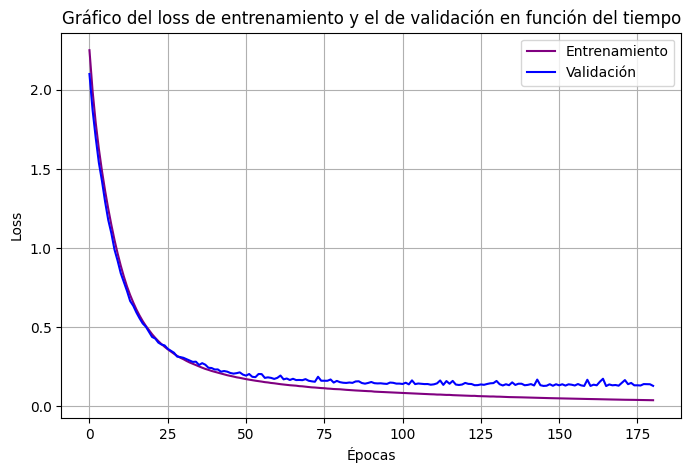

Precisión:  0.9670498084291188


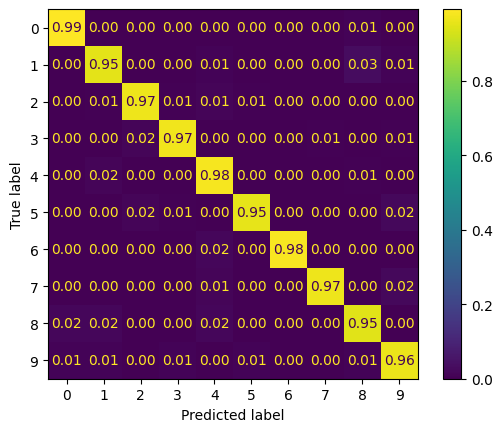

In [ ]:
model1 = NeuralNetwork(input_size=64, hidden_size1=10, hidden_size2=None, output_size=10, activation_function=nn.Tanh())
loss_train1, loss_val1 = train_model(model1, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(model1, dataloader_val)

Epoch: 0, train loss: 2.0685, val loss: 1.7789
Epoch: 1, train loss: 1.5530, val loss: 1.3261
Epoch: 2, train loss: 1.1592, val loss: 0.9879
Epoch: 3, train loss: 0.8729, val loss: 0.7394
Epoch: 4, train loss: 0.6742, val loss: 0.5809
Epoch: 5, train loss: 0.5362, val loss: 0.4837
Epoch: 6, train loss: 0.4406, val loss: 0.4029
Epoch: 7, train loss: 0.3710, val loss: 0.3552
Epoch: 8, train loss: 0.3208, val loss: 0.2944
Epoch: 9, train loss: 0.2824, val loss: 0.2747
Epoch: 10, train loss: 0.2533, val loss: 0.2475
Epoch: 11, train loss: 0.2303, val loss: 0.2257
Epoch: 12, train loss: 0.2093, val loss: 0.2100
Epoch: 13, train loss: 0.1938, val loss: 0.1938
Epoch: 14, train loss: 0.1794, val loss: 0.1830
Epoch: 15, train loss: 0.1678, val loss: 0.1815
Epoch: 16, train loss: 0.1577, val loss: 0.1604
Epoch: 17, train loss: 0.1479, val loss: 0.1611
Epoch: 18, train loss: 0.1399, val loss: 0.1568
Epoch: 19, train loss: 0.1322, val loss: 0.1466
Epoch: 20, train loss: 0.1251, val loss: 0.1472
Ep

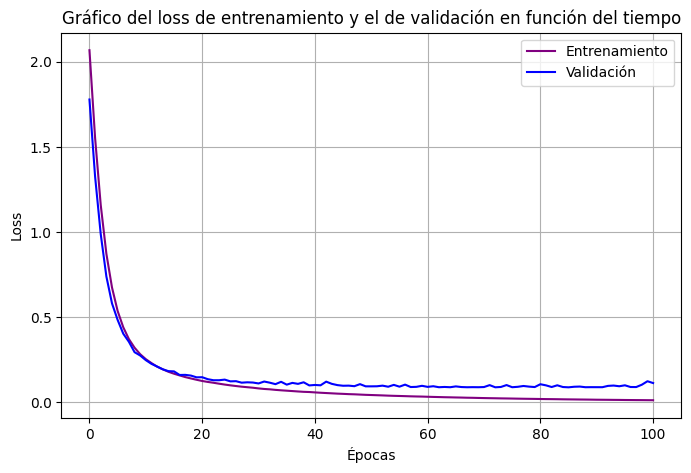

Precisión:  0.9724137931034482


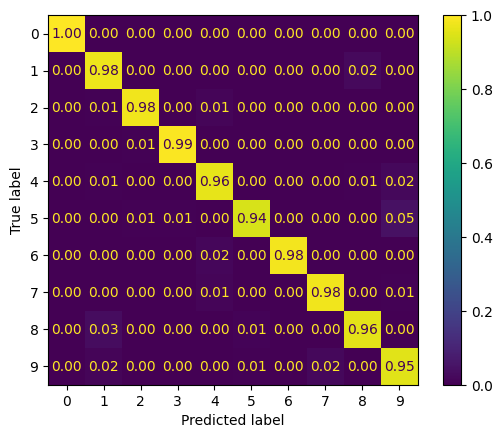

In [ ]:
model1 = NeuralNetwork(input_size=64, hidden_size1=40, hidden_size2=None, output_size=10, activation_function=nn.Tanh())
loss_train1, loss_val1 = train_model(model1, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(model1, dataloader_val)

Epoch: 0, train loss: 2.2779, val loss: 2.2341
Epoch: 1, train loss: 2.1784, val loss: 2.1008
Epoch: 2, train loss: 2.0184, val loss: 1.8961
Epoch: 3, train loss: 1.8080, val loss: 1.6786
Epoch: 4, train loss: 1.5960, val loss: 1.4535
Epoch: 5, train loss: 1.3995, val loss: 1.3023
Epoch: 6, train loss: 1.2178, val loss: 1.1383
Epoch: 7, train loss: 1.0634, val loss: 0.9831
Epoch: 8, train loss: 0.9335, val loss: 0.8543
Epoch: 9, train loss: 0.8238, val loss: 0.7626
Epoch: 10, train loss: 0.7296, val loss: 0.6810
Epoch: 11, train loss: 0.6451, val loss: 0.6020
Epoch: 12, train loss: 0.5713, val loss: 0.5575
Epoch: 13, train loss: 0.5072, val loss: 0.4774
Epoch: 14, train loss: 0.4526, val loss: 0.4419
Epoch: 15, train loss: 0.4044, val loss: 0.3980
Epoch: 16, train loss: 0.3657, val loss: 0.3794
Epoch: 17, train loss: 0.3309, val loss: 0.3393
Epoch: 18, train loss: 0.3028, val loss: 0.3136
Epoch: 19, train loss: 0.2782, val loss: 0.3049
Epoch: 20, train loss: 0.2562, val loss: 0.2818
Ep

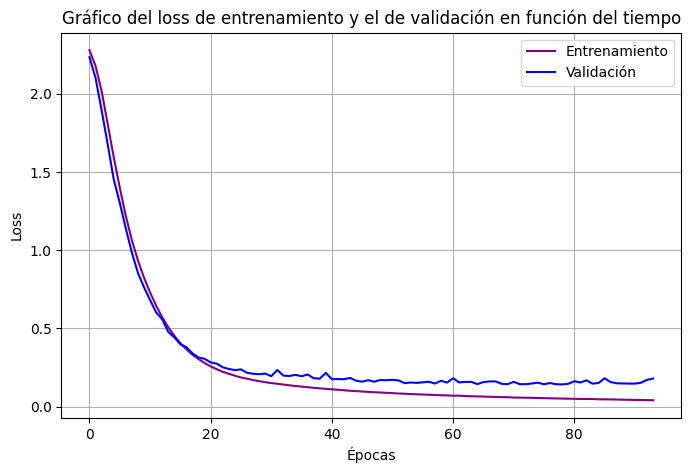

Precisión:  0.9555555555555556


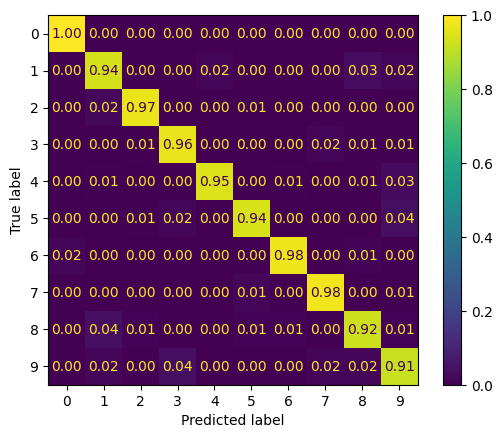

In [ ]:
model1 = NeuralNetwork(input_size=64, hidden_size1=10, hidden_size2=10, output_size=10, activation_function=nn.ReLU())
loss_train1, loss_val1 = train_model(model1, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(model1, dataloader_val)

Epoch: 0, train loss: 2.2059, val loss: 2.0643
Epoch: 1, train loss: 1.8375, val loss: 1.5136
Epoch: 2, train loss: 1.2003, val loss: 0.8651
Epoch: 3, train loss: 0.6622, val loss: 0.4774
Epoch: 4, train loss: 0.3883, val loss: 0.3128
Epoch: 5, train loss: 0.2671, val loss: 0.2345
Epoch: 6, train loss: 0.2055, val loss: 0.1874
Epoch: 7, train loss: 0.1686, val loss: 0.1691
Epoch: 8, train loss: 0.1425, val loss: 0.1618
Epoch: 9, train loss: 0.1244, val loss: 0.1469
Epoch: 10, train loss: 0.1099, val loss: 0.1304
Epoch: 11, train loss: 0.0981, val loss: 0.1230
Epoch: 12, train loss: 0.0888, val loss: 0.1106
Epoch: 13, train loss: 0.0804, val loss: 0.1102
Epoch: 14, train loss: 0.0738, val loss: 0.1084
Epoch: 15, train loss: 0.0674, val loss: 0.1218
Epoch: 16, train loss: 0.0605, val loss: 0.1014
Epoch: 17, train loss: 0.0554, val loss: 0.1060
Epoch: 18, train loss: 0.0510, val loss: 0.0968
Epoch: 19, train loss: 0.0472, val loss: 0.0879
Epoch: 20, train loss: 0.0442, val loss: 0.0991
Ep

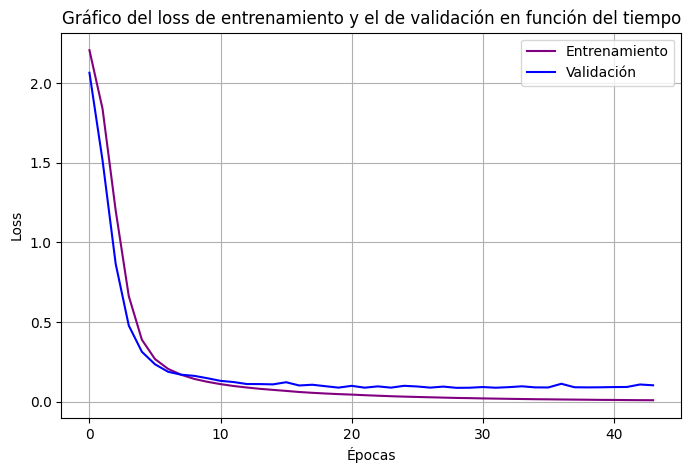

Precisión:  0.9739463601532568


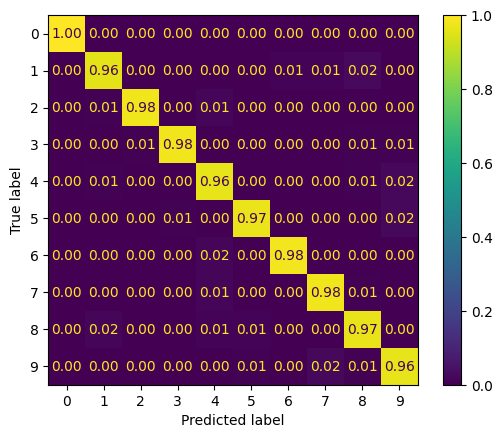

In [ ]:
model1 = NeuralNetwork(input_size=64, hidden_size1=40, hidden_size2=40, output_size=10, activation_function=nn.ReLU())
loss_train1, loss_val1 = train_model(model1, dataloader_train, dataloader_val)
plot_loss(range(len(loss_train1)), loss_train1, loss_val1)
evaluate_model(model1, dataloader_val)